# MP Plus data train

加入物理特征进行训练
**物理特征包括：**
nsites、crystal_system、space_group、volume、density、
density_atomic、efermi、energy_per_atom、formation_energy_per_atom、is_gap_direct、is_oxide


In [6]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'XGBoost'

In [7]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts'

In [8]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [9]:
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load Data

In [10]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_plus_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_plus_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']

dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']


In [11]:
dft_train.shape, dft_test.shape

((4412, 145), (1108, 145))

## Model Train

### DFT Model

In [12]:
fig_path = os.path.join(current_path, 'figures', 'MP_plus')
os.makedirs(fig_path, exist_ok=True)

####################################################################################################
[DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.6s
Model training completed!
[Train_error] Evaluating DFT XGBoost on DFT train set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\MP_plus\train_error.png


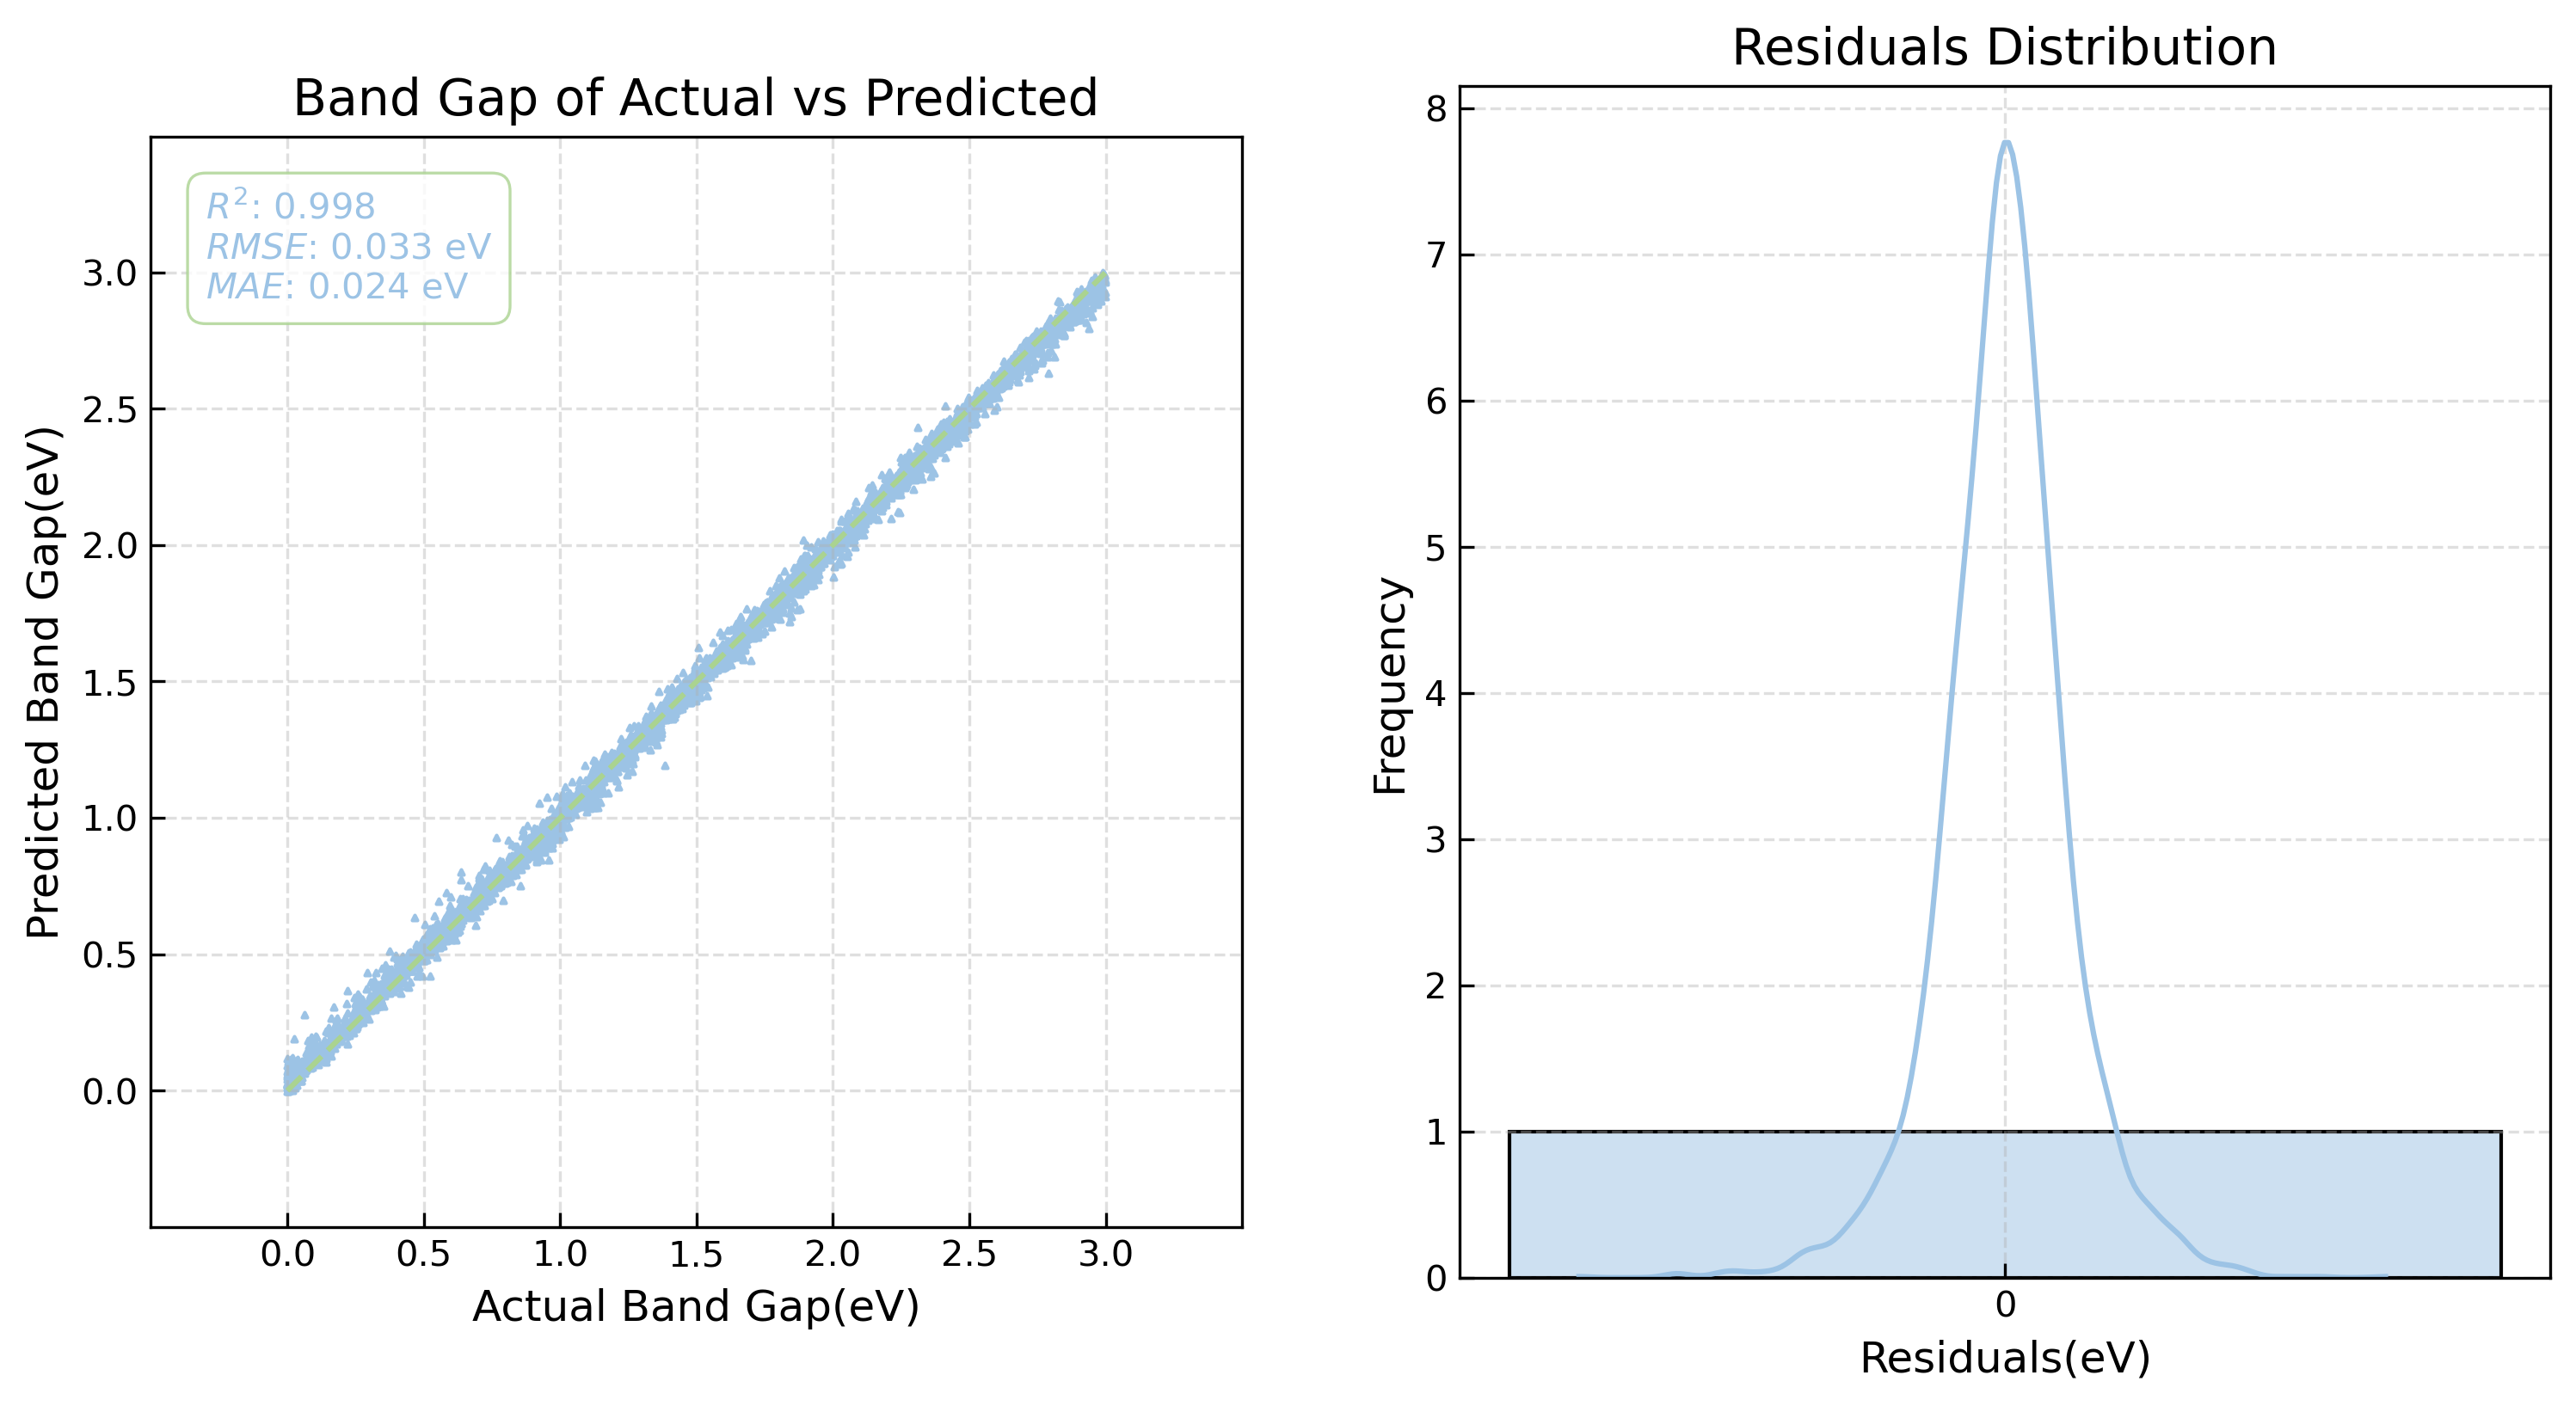


Model Evaluation Results:
Test set size: 4412
Test set: R²: 0.9985 RMSE: 0.0330 MAE: 0.0239 MAPE: 84.8860%
[Test DFT -> DFT] Evaluating DFT XGBoost on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\MP_plus\test_error.png


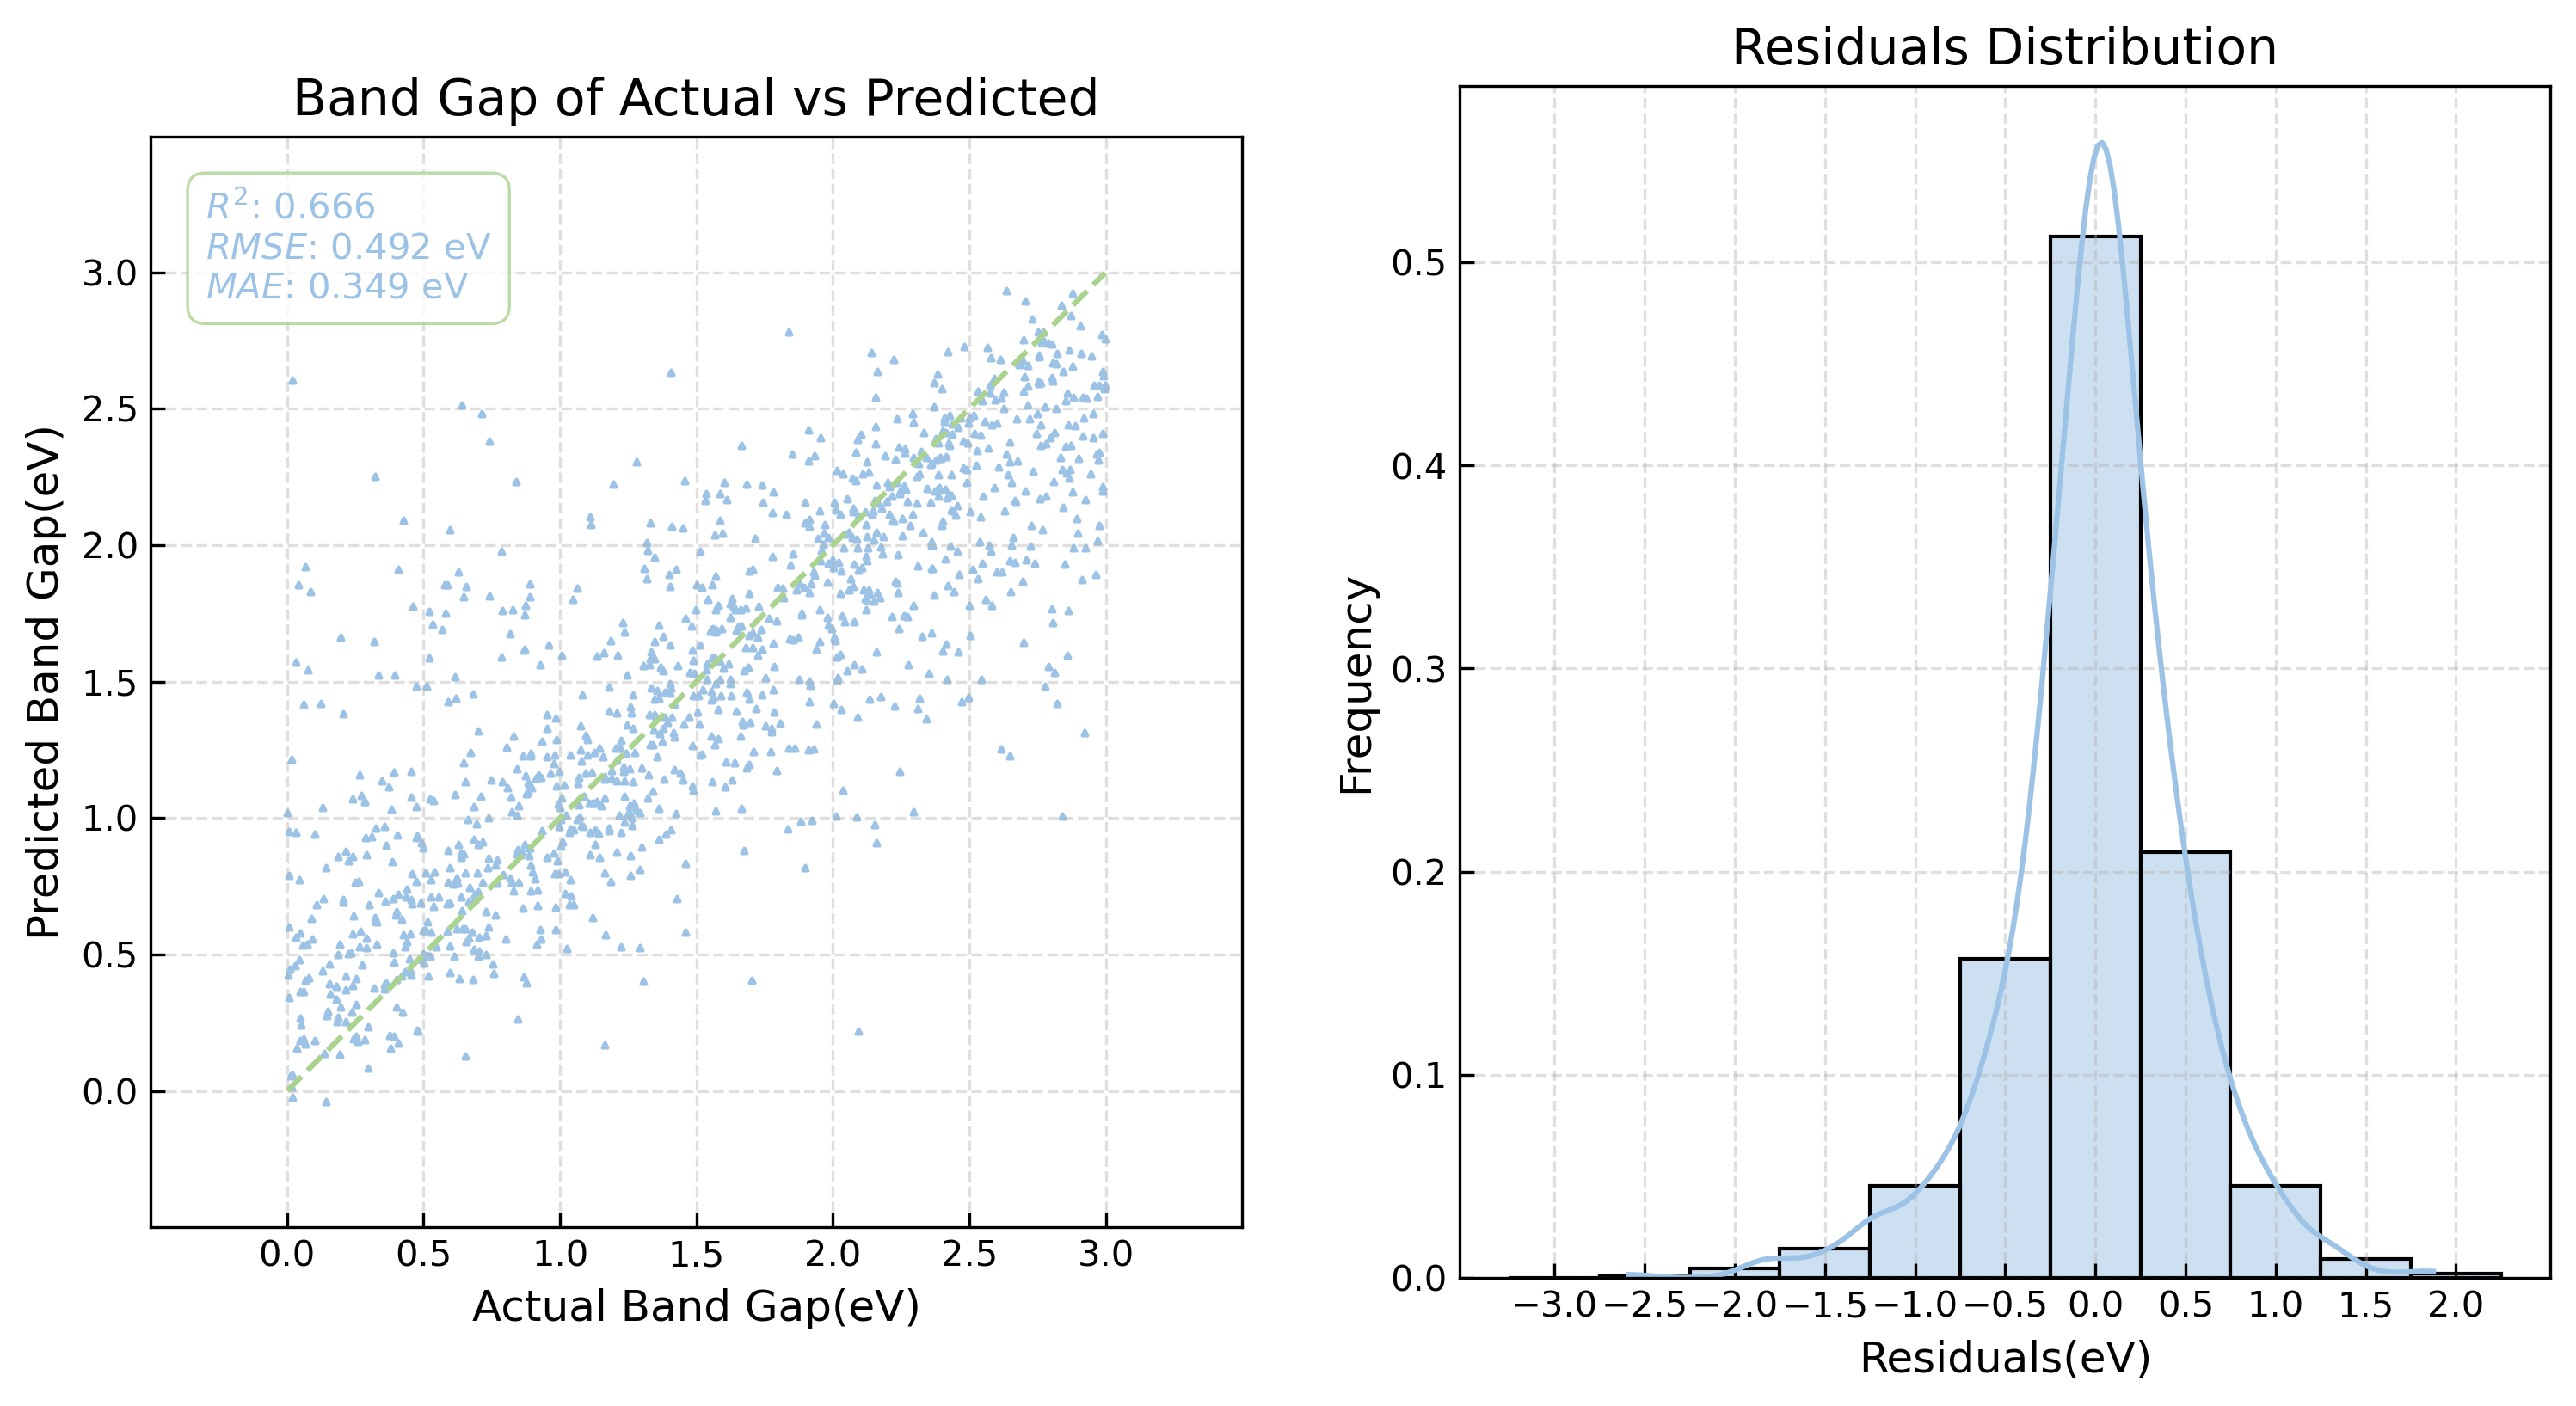


Model Evaluation Results:
Test set size: 1108
Test set: R²: 0.6663 RMSE: 0.4918 MAE: 0.3493 MAPE: 220.7468%


In [13]:
xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y, fig_path=os.path.join(fig_path, 'train_error.png'))
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y, fig_path=os.path.join(fig_path, 'test_error.png'))
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\MP_plus\feature_importance.png


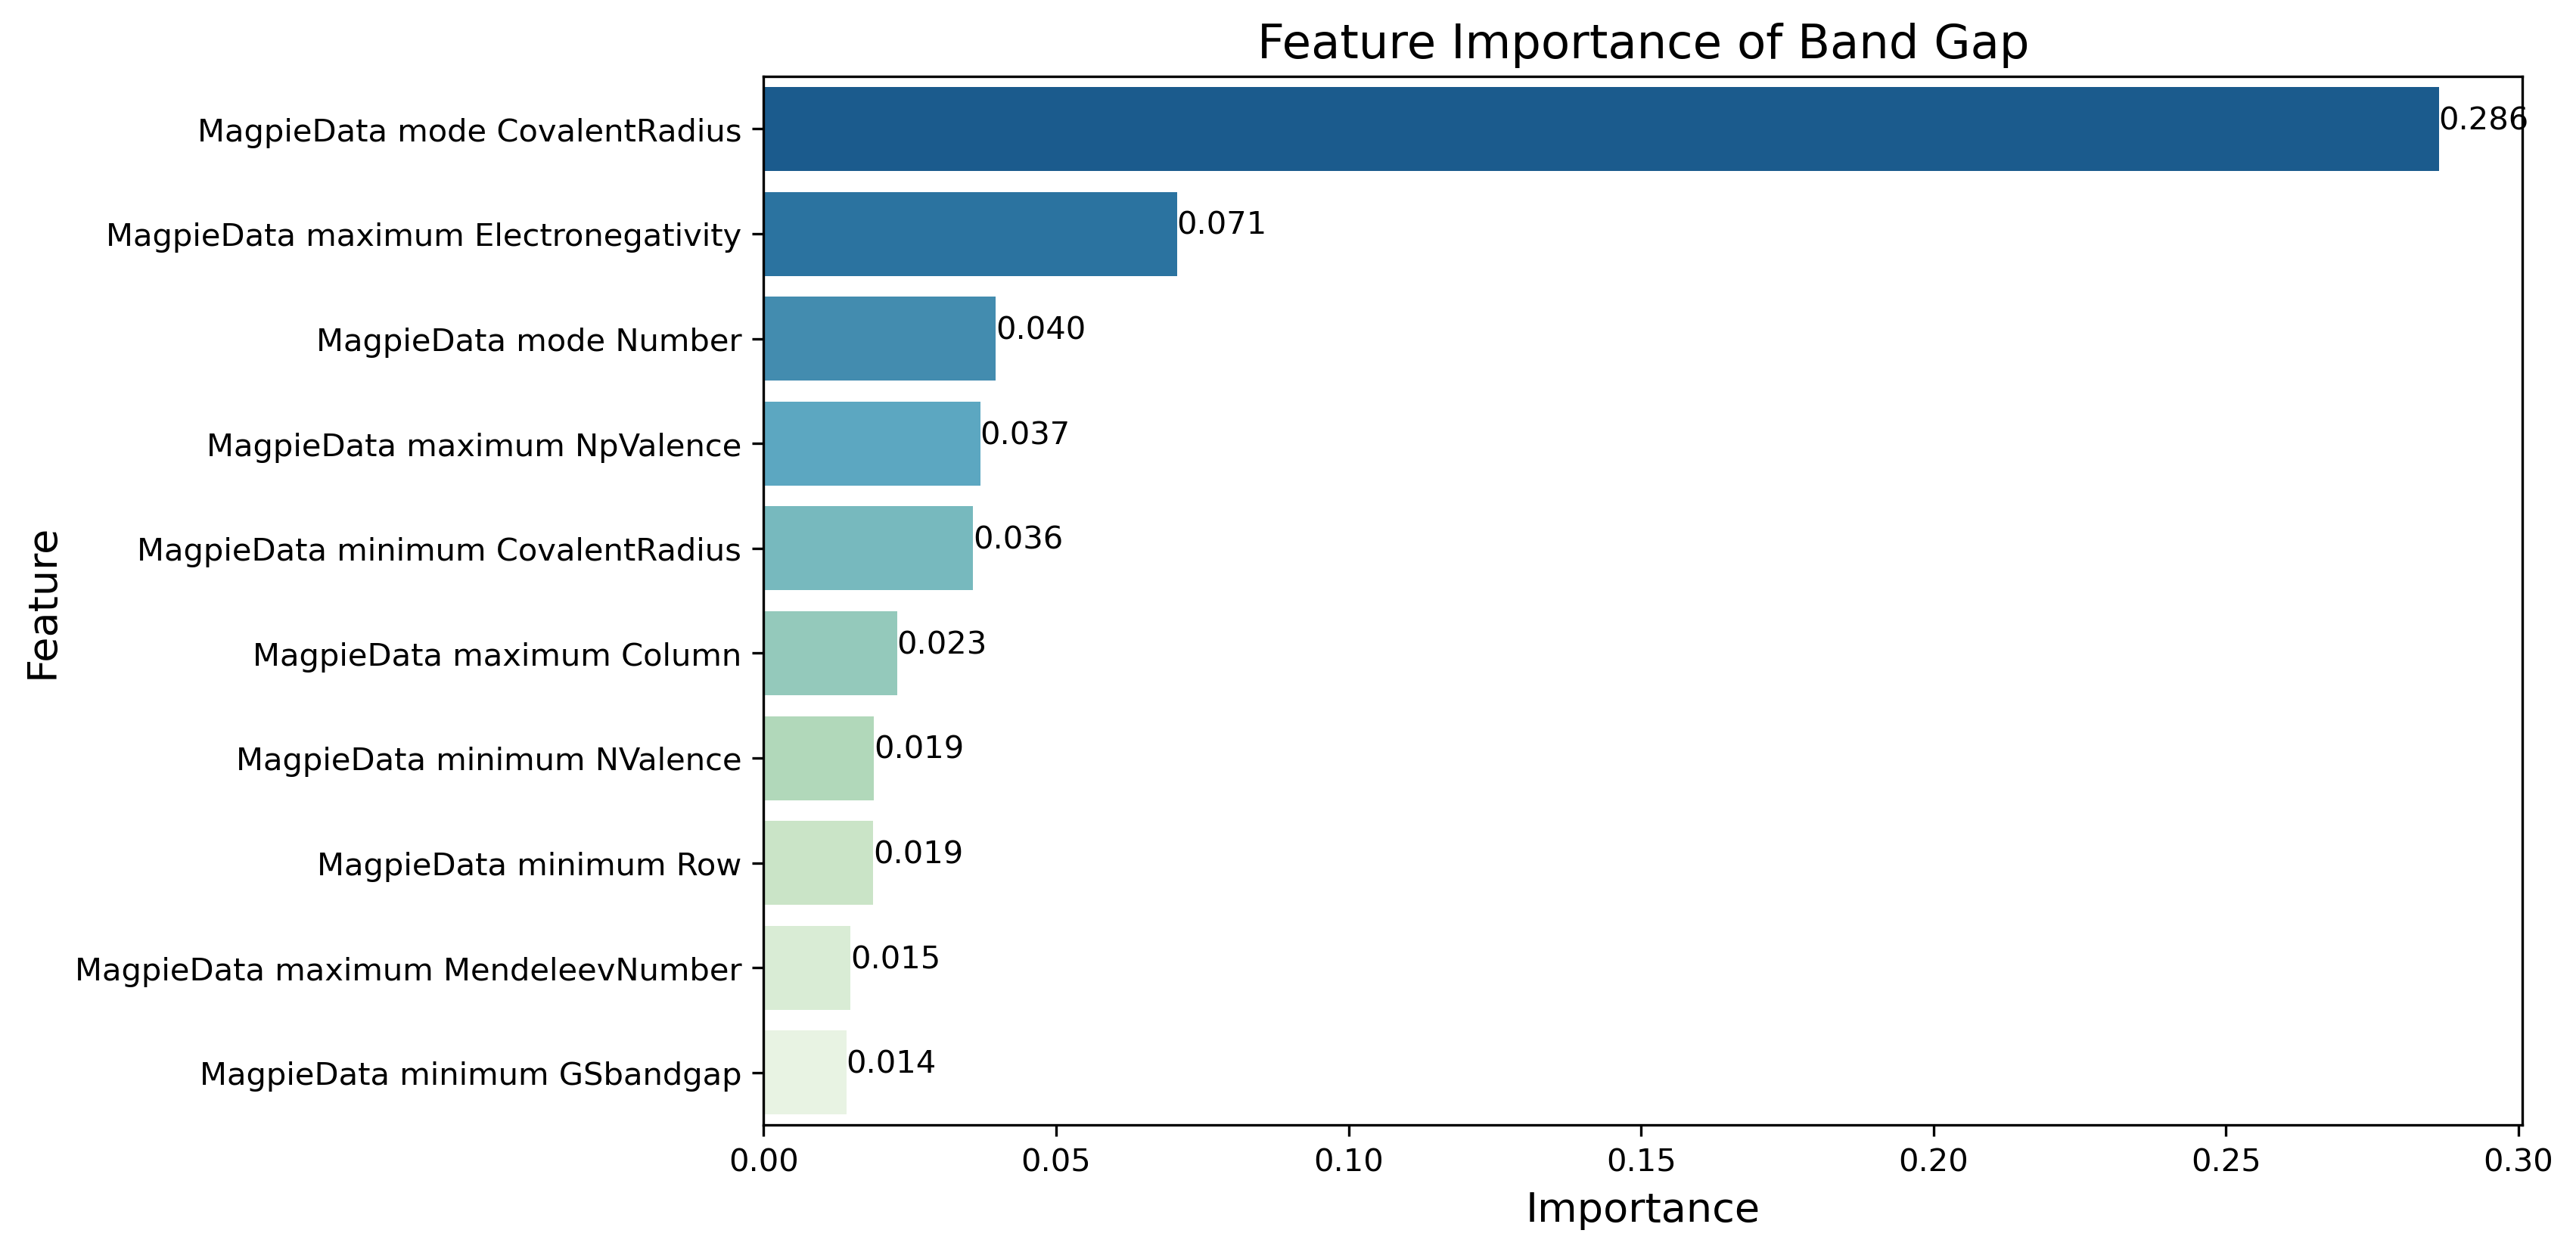

In [15]:
# 绘制特征重要性图
from Utools.draw import plot_feature_importance
importances_df = plot_feature_importance(dft_model.get_model(), dft_train_X.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'feature_importance.png'))  

In [14]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,XGBoost,Train,dft,dft,0.998477,0.032984,0.023905
1,XGBoost,Test,dft,dft,0.666303,0.491803,0.349274


In [16]:
# Save the model metrics to a CSV file
model_metrics.to_csv(os.path.join('./metrics', 'mp_plus_metrics.csv'), index=False)